In [14]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
from pathlib import Path
import pandas as pd
from scipy import ndimage
import pmesh
from mpi4py import MPI
from nbodykit.algorithms import FFTPower
import matplotlib.gridspec as gridspec

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Load the data for a particular mock (sample from the Latin Hypercube (LH)).

In [15]:
tag_params = '_p5_n10000'
idx_LH = 0

# change this directory path as needed
dir_mocks = f'/scratch/users/kstoreyf/muchisimocks/muchisimocks_lib{tag_params}'
subdir_prefix = 'LH'
fn_fields = f'{dir_mocks}/{subdir_prefix}{idx_LH}/bias_fields_eul_deconvolved_{idx_LH}.npy'
fn_fields_zspace = f'{dir_mocks}/{subdir_prefix}{idx_LH}/bias_fields_eul_zspace_deconvolved_{idx_LH}.npy'

bias_terms_eul = np.load(fn_fields)
bias_terms_eul_zspace = np.load(fn_fields_zspace)

Define plotting code

In [16]:
# copied from plotter.py (so that this notebook is self-contained)
def plot_field(tracer_field, normalize=False, vmin=None, vmax=None, 
                title=None, show_labels=True, show_colorbar=True,
                zslice_min=0, zslice_max=1, figsize=(6,6), log=False, symlog=False, 
                overdensity=True, label_cbar=None, plot = 'xy', interpolation = None):

        if normalize:
            tracer_field /= np.max(np.abs(tracer_field))
        
        if vmax is None:
            vmax = 3*np.std(tracer_field)
       
        if tracer_field.ndim==3:
            if plot == 'xy':
                field_2d = np.mean(tracer_field[:,:,zslice_min:zslice_max], axis=-1)
            elif plot == 'xz':
                field_2d = np.mean(tracer_field[:,zslice_min:zslice_max,:], axis=1)
            elif plot == 'yz':
                field_2d = np.mean(tracer_field[zslice_min:zslice_max,:,:], axis=0)
        elif tracer_field.ndim==2:
            field_2d = tracer_field
        else:
            raise ValueError("field must be 2d or 3d!")

        plt.figure(figsize=figsize, facecolor=(1,1,1,0))
        plt.title(title, fontsize=16)
        
        if symlog:
            from matplotlib.colors import SymLogNorm
            linthresh = 0.1*vmax
            linscale = 1.0
            if vmin is None:
                vmin = -vmax
            norm = SymLogNorm(
                    linthresh=linthresh, linscale=linscale,
                    vmin=vmin, vmax=vmax
                    )
        elif log:
            if vmin is None:
                vmin = np.min(tracer_field[tracer_field>0])
            norm = mpl.colors.LogNorm(vmin=vmin, vmax=vmax)
        else:
            if vmin is None:
                if overdensity:
                    vmin = -vmax
                else:
                    vmin = np.min(tracer_field[tracer_field>0])
            norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)

        if overdensity:
            cmap = 'RdBu'
        else:
            cmap = 'Blues'
                
        im = plt.imshow(field_2d, norm=norm, cmap=cmap, interpolation = interpolation)
        ax = plt.gca()        
        
        if show_colorbar:
            if label_cbar is None:
                if overdensity:
                    label_cbar = r'overdensity $\delta$'
                else:
                    label_cbar = r'density'
            cbar = plt.colorbar(im, label=label_cbar, fraction=0.046, pad=0.04)
            cbar.ax.tick_params(labelsize=12) 
            
        if not show_labels:    
            ax.axes.get_xaxis().set_visible(False)
            ax.axes.get_yaxis().set_visible(False)

        plt.show()

Plot the individual five bias fields

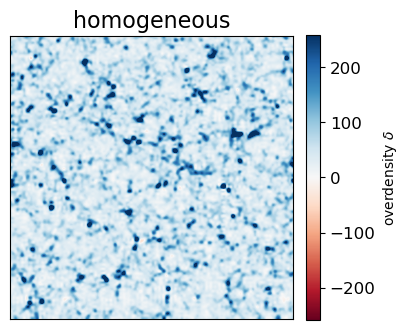

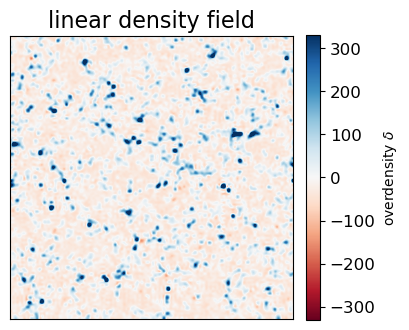

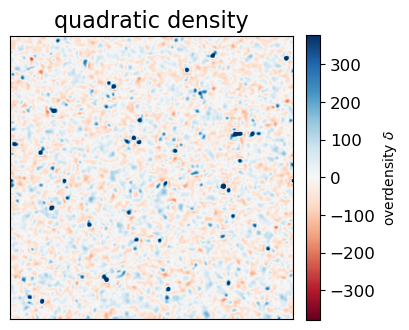

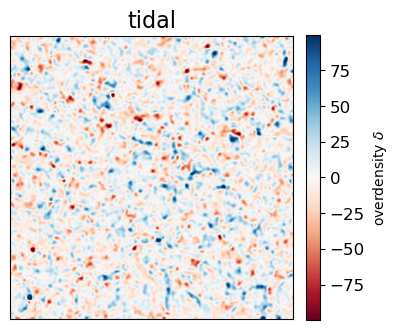

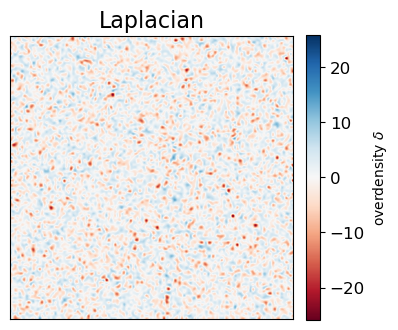

In [17]:
bias_field_labels = ['homogeneous', 'linear density field', 'quadratic density', 'tidal', 'Laplacian']
for i in range(len(bias_terms_eul)):
    plot_field(bias_terms_eul[i], figsize=(4,4), title=bias_field_labels[i], interpolation = 'bicubic',
                       show_labels=False)

Define code to combine the fields

In [18]:
# copied from utils.py (so that this notebook is self-contained)
def get_tracer_field(bias_fields_eul, bias_vector, n_grid_norm=None):
    assert len(bias_vector)==bias_fields_eul.shape[0]-1, "bias_vector must have length one less than number of bias fields"
    if n_grid_norm is None:
        n_grid_norm = bias_fields_eul.shape[-1]
        
    def _sum_bias_fields(fields, bias_vector):
        bias_vector_extended = np.concatenate(([1.0], bias_vector))
        return np.sum([fields[ii]*bias_vector_extended[ii] for ii in range(len(fields))], axis=0)
    
    tracer_field_eul = _sum_bias_fields(bias_fields_eul, bias_vector)
    tracer_field_eul_norm = tracer_field_eul/n_grid_norm**3
    
    return tracer_field_eul_norm

Choose some bias vector and combine the bias fields into a tracer field

In [19]:
#the order is b1, b2, bs2, blaplacian
bias_params = [1, 0.5, 0.5, 0.5]
# use 512 for normalization, because this is the original resolution of the mocks (they were downsampled to 128)
# this doesn't matter for visualization, but will when you go to compute statistics
n_grid_orig = 512
tracer_field_eul_norm = get_tracer_field(bias_terms_eul, bias_params, n_grid_norm=n_grid_orig)


Plot final tracer field

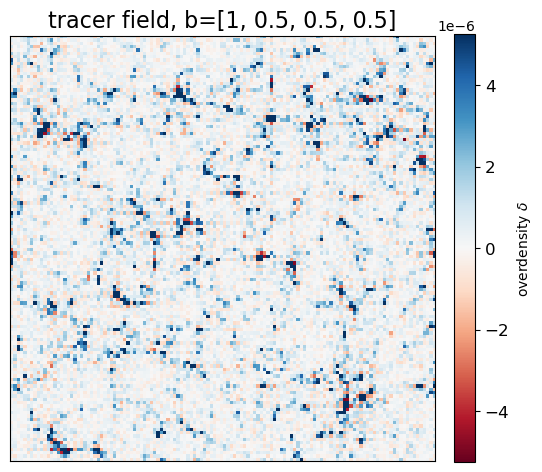

In [20]:
plot_field(tracer_field_eul_norm, figsize=(6,6), title=f'tracer field, b={bias_params}', plot = 'xz',
                   show_labels=False, vmin=-5.25e-6, vmax=5.25e-6)

Now plot in redshift-space! 

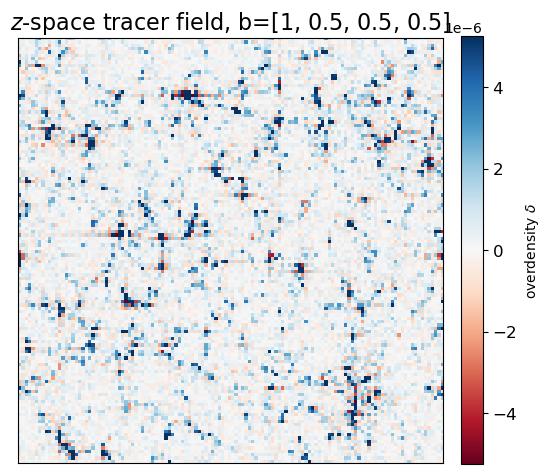

In [21]:
tracer_field_eul_norm_zspace = get_tracer_field(bias_terms_eul_zspace, bias_params, n_grid_norm=n_grid_orig)

plot_field(tracer_field_eul_norm_zspace, figsize=(6,6), title=rf'$z$-space tracer field, b={bias_params}', plot = 'xz',
                   show_labels=False, vmin=-5.25e-6, vmax=5.25e-6)

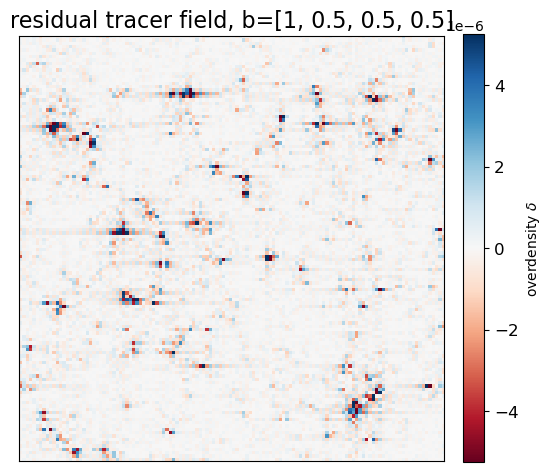

In [22]:
plot_field(tracer_field_eul_norm-tracer_field_eul_norm_zspace, figsize=(6,6), title=rf'residual tracer field, b={bias_params}', plot = 'xz',
                   show_labels=False, vmin=-5.25e-6, vmax=5.25e-6)

Read in the cosmological parameters associated with this mock

In [23]:
# copied from data_loader.py (so that this notebook is self-contained)
def load_cosmo_params(tag_params, dir_params='../data/params'):
    fn_params = f'{dir_params}/params_lh{tag_params}.txt'
    fn_params_fixed = f'{dir_params}/params_fixed{tag_params}.txt'
    
    params_df = (
        pd.read_csv(fn_params, index_col=0)
        if os.path.exists(fn_params)
        else None
    )
    param_dict_fixed = (
        pd.read_csv(fn_params_fixed).iloc[0].to_dict() 
        if os.path.exists(fn_params_fixed)
        else {}
    )
    return params_df, param_dict_fixed

In [24]:
# the mock directory should contain these parameter files; or they might be in a central directory (default)
params_df, param_dict_fixed = load_cosmo_params(tag_params=tag_params, dir_params=dir_mocks)

In [25]:
print('fixed parameters:')
for key in param_dict_fixed.keys():
    print(f'{key}: {param_dict_fixed[key]:.3f}')

fixed parameters:
neutrino_mass: 0.000
w0: -1.000
wa: 0.000


In [26]:
print('parameters varied in LH:')
param_dict_vary = params_df.loc[idx_LH].to_dict()
for key in param_dict_vary.keys():
    print(f'{key}: {param_dict_vary[key]:.3f}')

parameters varied in LH:
omega_cold: 0.237
sigma8_cold: 0.698
hubble: 0.664
omega_baryon: 0.049
ns: 0.957


# Construct the fields in z space
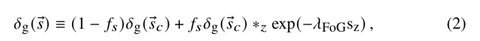
## Start with large-scale RSDs: $\left(1-f_s\right) \delta_{\mathrm{g}}\left(\vec{s}_c\right)$

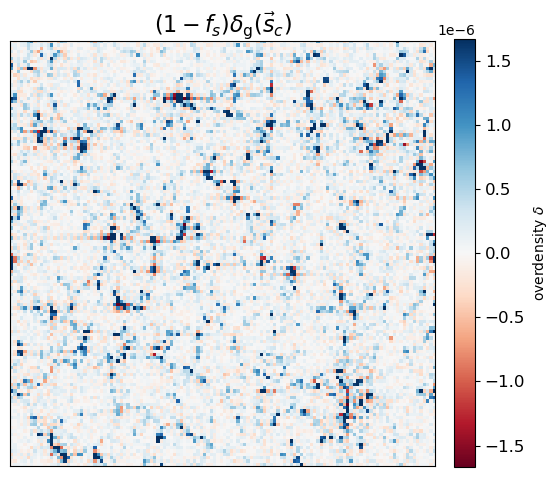

In [27]:
f_sat = 0.7
RSD_large = tracer_field_eul_norm_zspace*(1-f_sat)
plot_field(RSD_large, figsize=(6,6), title=r'$(1-f_s) \delta_{\mathrm{g}}(\vec{s}_c)$', plot = 'xz',
                   show_labels=False)

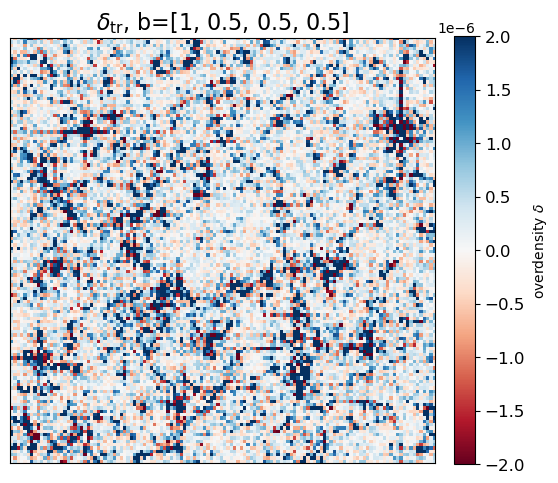

In [28]:
plot_field(tracer_field_eul_norm, figsize=(6,6), title=f'$\delta_\mathrm{{tr}}$, b={bias_params}', plot = 'yz',
                   show_labels=False, vmin=-2e-6, vmax=2e-6)

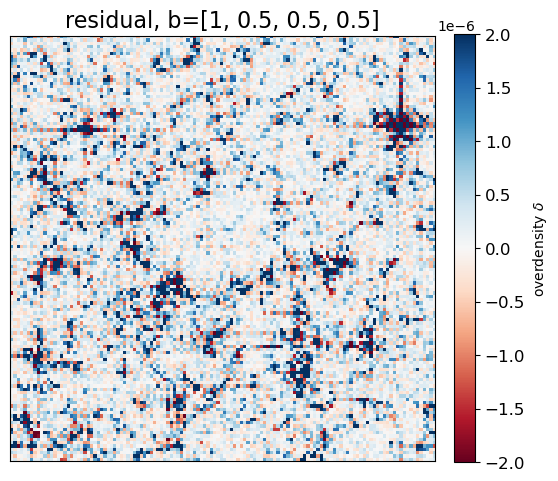

In [29]:
plot_field(tracer_field_eul_norm-RSD_large, figsize=(6,6), title=rf'residual, b={bias_params}', plot = 'yz',
                   show_labels=False, vmin=-2e-6, vmax=2e-6)

## Now compute small-scale RSDs: $f_s \delta_{\mathrm{g}}\left(\vec{s}_c\right) *_z \exp \left(-\lambda_{\mathrm{FoG}} \mathrm{~s}_{\mathrm{z}}\right)$

In [30]:
Lbox = 1000 # h/Mpc
Nbox = len(tracer_field_eul_norm_zspace)

In [31]:
def Lkernel_func(N, Lbox = Lbox, Nbox = Nbox):
    
    return Lbox/Nbox*N # Mpc/h

def s_z_func(N, Lbox = Lbox, Nbox = Nbox):
    
    Lkernel = Lkernel_func(N)
    s_z = np.linspace(-Lkernel/2, Lkernel/2, N+1) # Mpc/h

    if np.diff(s_z)[0] != Lbox/Nbox:
        raise TypeError("make sure the kernel spacing matches the grid spacing")
        
    return s_z

def kernel_func(s_z, lambda_FOG = 0.3):
    
    # normalize the kernel
    kernel = np.exp(-lambda_FOG*np.abs(s_z))
    norm = np.sum(kernel)

    return kernel/norm

In [32]:
N = 30
# s_z_max = s_z_func(Nbox-2)
# s_z_min = s_z_func(N_min)
# np.diff(s_z)[0] == Lbox/Nbox, np.diff(s_z_max)[0] == Lbox/Nbox, np.diff(s_z_min)[0] == Lbox/Nbox # make sure the kernel spacing matches the grid spacing

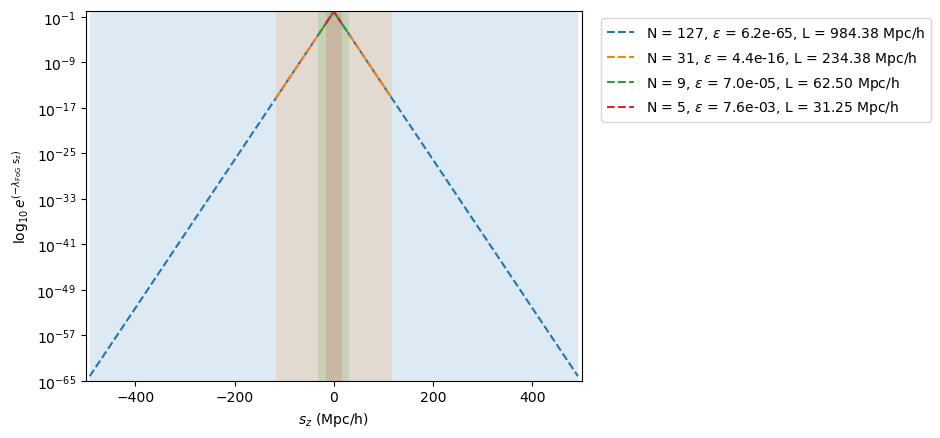

In [33]:
# kernel_max = kernel_func(s_z_max)
# kernel = kernel_func(s_z)
# Lkernel = Lkernel_func(N_kernel)
# Lkernel_min = Lkernel_func(N_min)
ymin, ymax = 1e-65, 1

for N_kernel in [Nbox-2, N, 8, 4]:
    s_z = s_z_func(N_kernel)
    kernel = kernel_func(s_z)
    Lkernel = Lkernel_func(N_kernel)

    plt.plot(s_z, kernel, label = 'N = {:d}, $\epsilon$ = {:.1e}, L = {:.2f} Mpc/h'.format(N_kernel + 1, kernel[0], Lkernel), linestyle = '--')
    plt.fill_betweenx(np.linspace(ymin, ymax), -Lkernel/2, Lkernel/2, alpha = 0.15)
    
# plt.plot(s_z_max, kernel_max, label = 'Nkernel = 127, threshold = {:.1e}'.format(kernel_max[0]))
# plt.plot(s_z, kernel, linestyle = '--', label = 'Nkernel = 31, threshold = {:.1e}'.format(kernel[0]))
# plt.fill_betweenx(-Lkernel/2, Lkernel/2)
# plt.axvline(-Lkernel_min/2, linestyle = '--', color = 'red')
# plt.axvline(Lkernel_min/2, linestyle = '--', color = 'red')
plt.xlim(-Lbox/2, Lbox/2)
plt.ylim(ymin, ymax)
plt.yscale('log')
plt.xlabel('$s_z$ (Mpc/h)')
plt.ylabel('$\log_{10}e^{(-\lambda_{\mathrm{FoG}} \mathrm{~s}_{\mathrm{z}})}$')
plt.legend(bbox_to_anchor=(1.025, 1.0))
plt.show()

In [35]:
# pad input signal #jk don't do this since it's a periodic box
pad = np.zeros((Nbox,Nbox,1))
padded = np.append(np.append(pad,tracer_field_eul_norm_zspace, axis = 2), pad, axis = 2)

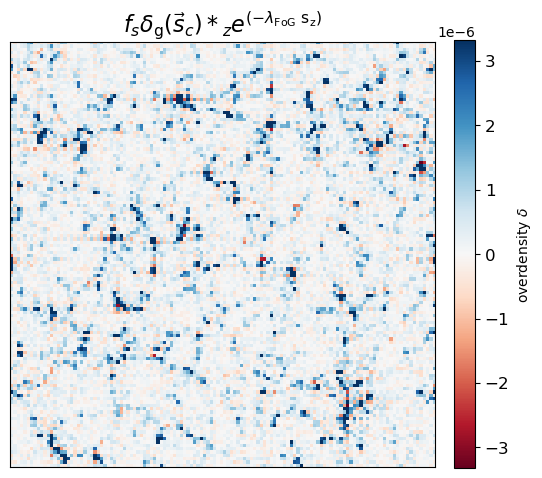

In [36]:
s_z = s_z_func(N)
RSD_small = f_sat*ndimage.convolve1d(tracer_field_eul_norm_zspace, kernel_func(s_z), mode = 'wrap')
plot_field(RSD_small, figsize=(6,6), title=r'$f_s \delta_{\mathrm{g}}(\vec{s}_c) *_z e^{(-\lambda_{\mathrm{FoG}} \mathrm{~s}_{\mathrm{z}})}$',
                   show_labels=False, plot = 'xz')

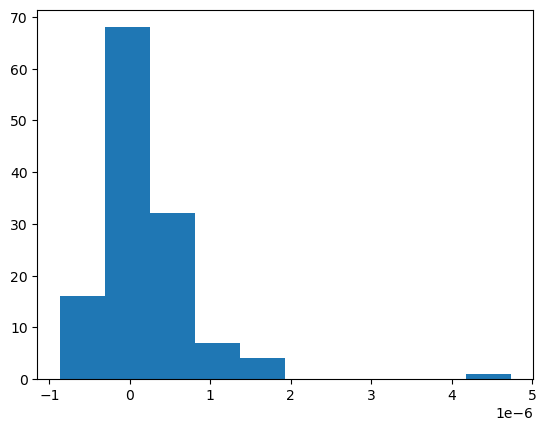

In [37]:
plt.hist(RSD_small[0,0,:])
plt.show()

## Add them together to get full RSDs

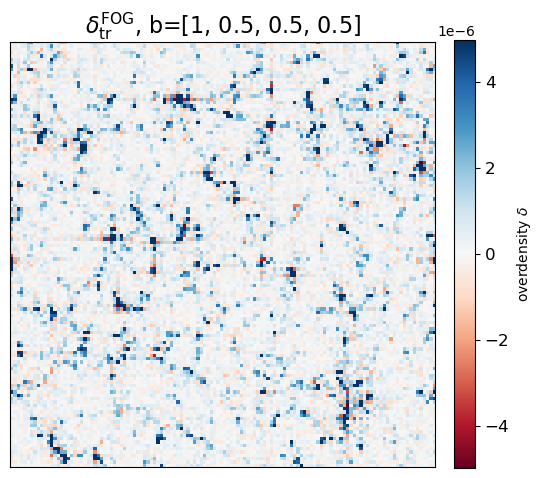

In [38]:
delta_FOG = RSD_large+RSD_small #[:,:,1:-1] # is this the correct way to get rid of extra dimensions?
plot_field(delta_FOG, figsize=(6,6), title=rf'$\delta_\mathrm{{tr}}^\mathrm{{FOG}}$, b={bias_params}', plot = 'xz',
                   show_labels=False)

## Plot clustering

In [43]:
def power_spectrum_err(f_z, ax0, ax1, label, f_real = tracer_field_eul_norm, res = Nbox, Lbox = Lbox, 
                       comm = MPI.COMM_WORLD, linestyle = '-', alpha = 1): #sm
        
    def lin_pk_func(f_z):
        
        pm = pmesh.pm.ParticleMesh([res, res, res], Lbox, dtype='float32', resampler='cic', comm=comm)

        # initialize a RealField
        gal_field = pmesh.pm.RealField(pm)
        gal_field[...]=f_z

        # Create the FFTPower objects
        lin_pk = FFTPower(gal_field.r2c(), '1d', kmin = 1e-5)

        # k arrays are set like this
        kvals = lin_pk.power['k'] # let's ignore the artificial zero k value
        
        return lin_pk.power['power'].real, kvals
    
    lin_pk_z, kvals_z = lin_pk_func(f_z)
    lin_pk_real, kvals_real = lin_pk_func(f_real)
    
    if (kvals_z!=kvals_real).any():
        raise TypeError("make sure the kvals are the same")

    # Plot the P(k)
    ax0.loglog(kvals_z, lin_pk_z, linestyle = linestyle, label = label, alpha = alpha) # lin_pk.power['power'].real[1:]
    ax0.set_xlim(kvals_z[0], kvals_z[-1])
    ax0.set_ylabel('P(k)')
    ax0.legend()
    ax0.set_xticks([])
    
    # Plot the ratio
    ax1.plot(kvals_z, lin_pk_z/lin_pk_real, linestyle = linestyle, label = label, alpha = alpha) # lin_pk.power['power'].real[1:]
    ax1.set_xscale('log')
    ax1.set_xlim(kvals_z[0], kvals_z[-1])
    ax1.set_xlabel('k (h/Mpc)')
    ax1.set_ylabel('P(k)$_\mathrm{z}$/P(k)$_\mathrm{real}$')

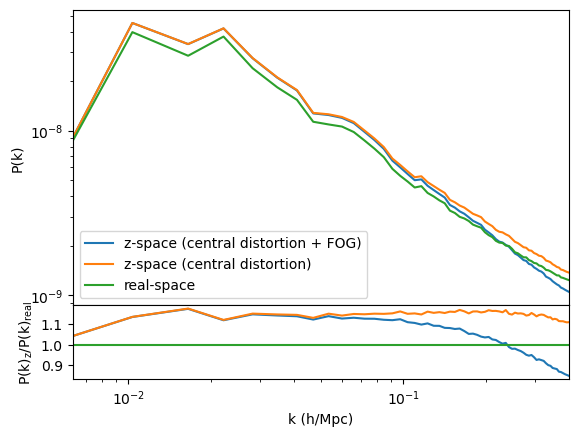

In [44]:
fig = plt.figure()
gs = gridspec.GridSpec(2, 1, height_ratios = [4,1])
gs.update(hspace = 0)

ax0 = fig.add_subplot(gs[0])
ax1 = fig.add_subplot(gs[1])

power_spectrum_err(delta_FOG, ax0, ax1, label = 'z-space (central distortion + FOG)')
power_spectrum_err(tracer_field_eul_norm_zspace, ax0, ax1, label = 'z-space (central distortion)')
power_spectrum_err(tracer_field_eul_norm, ax0, ax1, label = 'real-space')
plt.show()

In [41]:
def power_spectrum_err(f_z, fig, ax0, ax1, label, f_real = tracer_field_eul_norm, res = Nbox, Lbox = Lbox, 
                       comm = MPI.COMM_WORLD, linestyle = '-', alpha = 1): #sm
        
    def lin_pk_func(f_z):
        
        pm = pmesh.pm.ParticleMesh([res, res, res], Lbox, dtype='float32', resampler='cic', comm=comm)

        # initialize a RealField
        gal_field = pmesh.pm.RealField(pm)
        gal_field[...]=f_z

        # Create the FFTPower objects
        lin_pk = FFTPower(gal_field.r2c(), '1d', kmin = 1e-5)

        # k arrays are set like this
        kvals = lin_pk.power['k'] # let's ignore the artificial zero k value
        
        return lin_pk.power['power'].real, kvals
    
    lin_pk_z, kvals_z = lin_pk_func(f_z)
    lin_pk_real, kvals_real = lin_pk_func(f_real)
    
    if (kvals_z!=kvals_real).any():
        raise TypeError("make sure the kvals are the same")

    # Plot the P(k)
    ax0.plot(kvals_z, kvals_z**2*lin_pk_z, linestyle = linestyle, label = label, alpha = alpha) # lin_pk.power['power'].real[1:]
    ax0.set_xlim(kvals_z[0], kvals_z[-1])
    ax0.set_ylabel('k$^2$P(k)')
    ax0.legend()
    ax0.set_xticks([])
    
    # Plot the ratio
    ax1.plot(kvals_z, lin_pk_z/lin_pk_real, linestyle = linestyle, label = label, alpha = alpha) # lin_pk.power['power'].real[1:]
    ax1.set_xlim(kvals_z[0], kvals_z[-1])
    ax1.set_xlabel('k (h/Mpc)')
    ax1.set_ylabel('P(k)$_\mathrm{z}$/P(k)$_\mathrm{real}$')

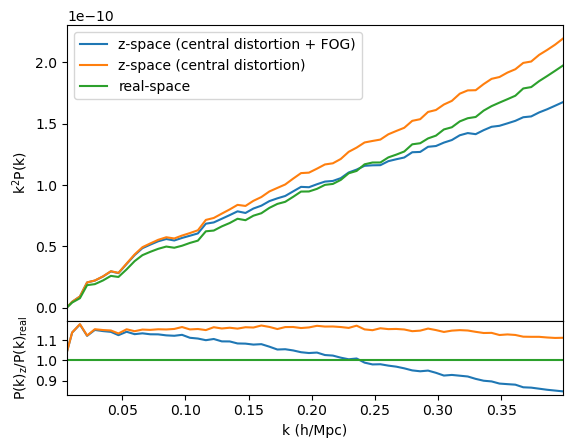

In [42]:
fig = plt.figure()
gs = gridspec.GridSpec(2, 1, height_ratios = [4,1])
gs.update(hspace = 0)

ax0 = fig.add_subplot(gs[0])
ax1 = fig.add_subplot(gs[1])

power_spectrum_err(delta_FOG, fig, ax0, ax1, label = 'z-space (central distortion + FOG)')
power_spectrum_err(tracer_field_eul_norm_zspace, fig, ax0, ax1, label = 'z-space (central distortion)')
power_spectrum_err(tracer_field_eul_norm, fig, ax0, ax1, label = 'real-space')
plt.show()

Questions:
- how does density contrast of $s_z$ work? x is just a grid, then you transform it with centrals distortion... so now it's not just a grid, things have been displaced... then you find density contrast of those new displaced coordinates.. but it gets mapped to a regular grid when you plot it? 
    - is it because all the new displaced coordinates $s_z$ can be tied back to original x points, so if you do $\delta(s_z)$ it tells you overdensity at $s_z$, but you plot it at x... this is different than plotting overdensity at x to begin with? because not everything necessarily moves to the same s_z???? but doesn't it? maybe this is why they look the same? 
        - answer: it's the same grid!! s_z is just to denote that we have transformed OG density contrast
- should I be zooming in or smoothing more? (zslicemax = 3?)
- why does Lkernel have to be less than res? --> not sure if this is true, seems to asymptote with higher values
    - why is the kernel centered at zero? 
        - answer: just how it's defined!
    - why do we take the absolute value of the kernel?
- should I be plotting monopole/quadrupole etc?

# Debug convolution

In [27]:
g = np.meshgrid([1,2,3,4,5], [1,2,3,4,5], [1,2,3,4,5])[-1]

In [28]:
pad = np.zeros((5,5,1))

In [29]:
g_pad = np.append(np.append(pad,g, axis = 2), pad, axis = 2)
g_pad

array([[[0., 1., 2., 3., 4., 5., 0.],
        [0., 1., 2., 3., 4., 5., 0.],
        [0., 1., 2., 3., 4., 5., 0.],
        [0., 1., 2., 3., 4., 5., 0.],
        [0., 1., 2., 3., 4., 5., 0.]],

       [[0., 1., 2., 3., 4., 5., 0.],
        [0., 1., 2., 3., 4., 5., 0.],
        [0., 1., 2., 3., 4., 5., 0.],
        [0., 1., 2., 3., 4., 5., 0.],
        [0., 1., 2., 3., 4., 5., 0.]],

       [[0., 1., 2., 3., 4., 5., 0.],
        [0., 1., 2., 3., 4., 5., 0.],
        [0., 1., 2., 3., 4., 5., 0.],
        [0., 1., 2., 3., 4., 5., 0.],
        [0., 1., 2., 3., 4., 5., 0.]],

       [[0., 1., 2., 3., 4., 5., 0.],
        [0., 1., 2., 3., 4., 5., 0.],
        [0., 1., 2., 3., 4., 5., 0.],
        [0., 1., 2., 3., 4., 5., 0.],
        [0., 1., 2., 3., 4., 5., 0.]],

       [[0., 1., 2., 3., 4., 5., 0.],
        [0., 1., 2., 3., 4., 5., 0.],
        [0., 1., 2., 3., 4., 5., 0.],
        [0., 1., 2., 3., 4., 5., 0.],
        [0., 1., 2., 3., 4., 5., 0.]]])

In [30]:
ndimage.convolve1d(g, [3,2,1], mode = 'wrap')

array([[[13, 14, 20, 26, 17],
        [13, 14, 20, 26, 17],
        [13, 14, 20, 26, 17],
        [13, 14, 20, 26, 17],
        [13, 14, 20, 26, 17]],

       [[13, 14, 20, 26, 17],
        [13, 14, 20, 26, 17],
        [13, 14, 20, 26, 17],
        [13, 14, 20, 26, 17],
        [13, 14, 20, 26, 17]],

       [[13, 14, 20, 26, 17],
        [13, 14, 20, 26, 17],
        [13, 14, 20, 26, 17],
        [13, 14, 20, 26, 17],
        [13, 14, 20, 26, 17]],

       [[13, 14, 20, 26, 17],
        [13, 14, 20, 26, 17],
        [13, 14, 20, 26, 17],
        [13, 14, 20, 26, 17],
        [13, 14, 20, 26, 17]],

       [[13, 14, 20, 26, 17],
        [13, 14, 20, 26, 17],
        [13, 14, 20, 26, 17],
        [13, 14, 20, 26, 17],
        [13, 14, 20, 26, 17]]])

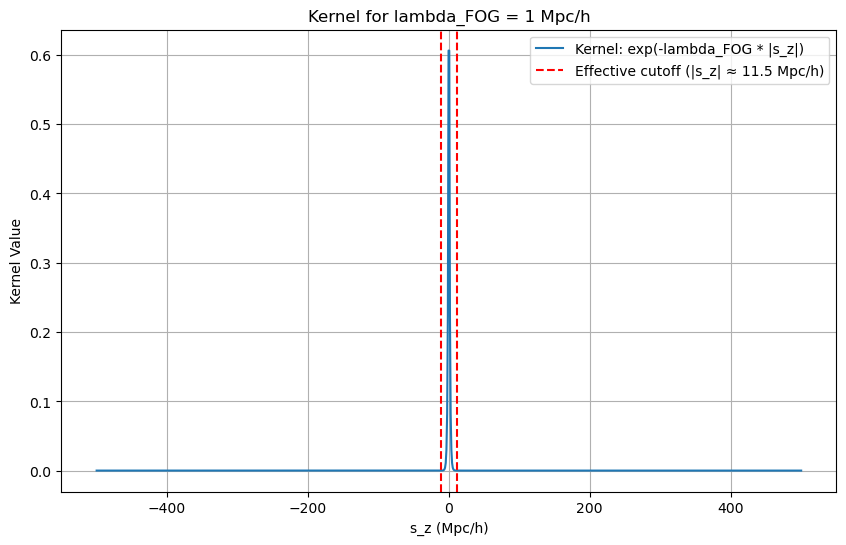

In [31]:
# Parameters # thanks chatgpt
L = 1000  # Box size in Mpc/h
lambda_FOG = 1  # Lambda_FOG in Mpc/h

# Define the range of s_z (from -L/2 to L/2)
s_z = np.linspace(-L/2, L/2, 1000)

# Define the kernel
kernel = np.exp(-lambda_FOG * np.abs(s_z))

# Plot the kernel
plt.figure(figsize=(10, 6))
plt.plot(s_z, kernel, label="Kernel: exp(-lambda_FOG * |s_z|)")
plt.axvline(x=11.5, color='r', linestyle='--', label='Effective cutoff (|s_z| ≈ 11.5 Mpc/h)')
plt.axvline(x=-11.5, color='r', linestyle='--')
plt.title(f"Kernel for lambda_FOG = {lambda_FOG} Mpc/h")
plt.xlabel("s_z (Mpc/h)")
plt.ylabel("Kernel Value")
plt.legend()
plt.grid(True)
plt.show()

In [32]:
ndimage.convolve1d([2, 8, 0, 4, 1, 9, 9, 0], weights=[1, 3])

array([14, 24,  4, 13, 12, 36, 27,  0])